In [2]:
import pandas as pd

df_raw = pd.read_csv("../Data/data.csv")
df_raw['TransactionStartTime'] = pd.to_datetime(df_raw['TransactionStartTime'])

snapshot_date = df_raw['TransactionStartTime'].max() + pd.Timedelta(days=1)

rfm_df = df_raw.groupby('CustomerId').agg(
    recency=('TransactionStartTime', lambda x: (snapshot_date - x.max()).days),
    frequency=('TransactionId', 'count'),
    monetary=('Amount', 'sum')            
).reset_index()

rfm_df.head()


,CustomerId,recency,frequency,monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


Cluster Centers:
      recency    frequency      monetary
0  61.485497     7.647790  8.166357e+04
1  29.000000  4091.000000 -1.049000e+08
2  12.502399    35.105539  2.744412e+05


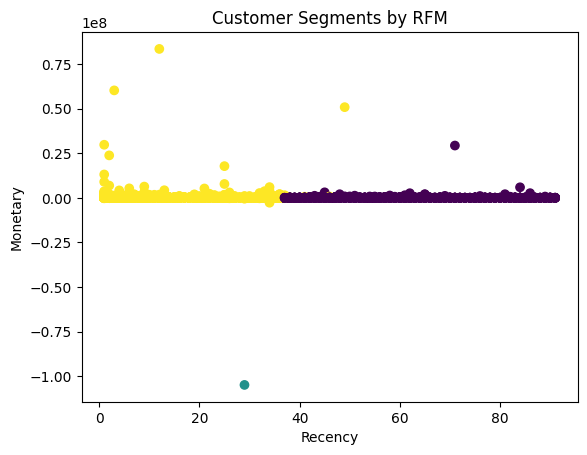

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

rfm_features = rfm_df[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                       columns=['recency', 'frequency', 'monetary'])
print("Cluster Centers:\n", centers)

plt.scatter(rfm_df['recency'], rfm_df['monetary'], c=rfm_df['cluster'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments by RFM')
plt.show()


In [4]:
high_risk_cluster = 0 

rfm_df['is_high_risk'] = rfm_df['cluster'].apply(lambda x: 1 if x == high_risk_cluster else 0)
rfm_df.drop(columns=['cluster'], inplace=True)
rfm_df.head()

,CustomerId,recency,frequency,monetary,is_high_risk
0,CustomerId_1,84,1,-10000.0,1
1,CustomerId_10,84,1,-10000.0,1
2,CustomerId_1001,90,5,20000.0,1
3,CustomerId_1002,26,11,4225.0,0
4,CustomerId_1003,12,6,20000.0,0


In [5]:
processed_df = pd.read_csv("../Data/processed_features.csv")

processed_df = processed_df.merge(rfm_df[['CustomerId', 'is_high_risk']], on='CustomerId', how='left')
processed_df.head()
processed_df.to_csv("../Data/processed_features_with_target.csv", index=False)